In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize

nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danielajimenez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielajimenez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load data 

In [2]:
# load df, drop unusable ratings, relabel
dt_path = "../01_data/txt_reports.csv"
df = pd.read_csv(dt_path)
df = df[
    df["quality_rating"].isin(["Substantial", "Modest", "High", "Negligible"])
].copy()
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["quality_rating"])


# clean data
def clean_text(text):
    """
    fn to clean text
    """
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^\w\s-]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~¡¿\d]', "", text)
        return text
    return ""


df["design_text_processed"] = df["design_text"].apply(clean_text)
df["implementation_text_processed"] = df["implementation_text"].apply(clean_text)
df["utilization_text_processed"] = df["utilization_text"].apply(clean_text)

## Descriptive Sentiment analysis

In [3]:
### Sentiment analysis
analyzer = SentimentIntensityAnalyzer()


def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment


# Apply sentiment analysis to each text section
df["design_sentiment"] = df["design_text"].apply(get_sentiment)
df["implementation_sentiment"] = df["implementation_text"].apply(get_sentiment)
df["utilization_sentiment"] = df["utilization_text"].apply(get_sentiment)


df["design_sentiment"] = df["design_text"].apply(get_sentiment)
df["implementation_sentiment"] = df["implementation_text"].apply(get_sentiment)
df["utilization_sentiment"] = df["utilization_text"].apply(get_sentiment)

# Extract sentiment scores into separate columns
df["design_pos"] = df["design_sentiment"].apply(lambda x: x["pos"])
df["design_neg"] = df["design_sentiment"].apply(lambda x: x["neg"])
df["design_neu"] = df["design_sentiment"].apply(lambda x: x["neu"])
df["design_compound"] = df["design_sentiment"].apply(lambda x: x["compound"])

df["implementation_pos"] = df["implementation_sentiment"].apply(lambda x: x["pos"])
df["implementation_neg"] = df["implementation_sentiment"].apply(lambda x: x["neg"])
df["implementation_neu"] = df["implementation_sentiment"].apply(lambda x: x["neu"])
df["implementation_compound"] = df["implementation_sentiment"].apply(
    lambda x: x["compound"]
)

df["utilization_pos"] = df["utilization_sentiment"].apply(lambda x: x["pos"])
df["utilization_neg"] = df["utilization_sentiment"].apply(lambda x: x["neg"])
df["utilization_neu"] = df["utilization_sentiment"].apply(lambda x: x["neu"])
df["utilization_compound"] = df["utilization_sentiment"].apply(lambda x: x["compound"])

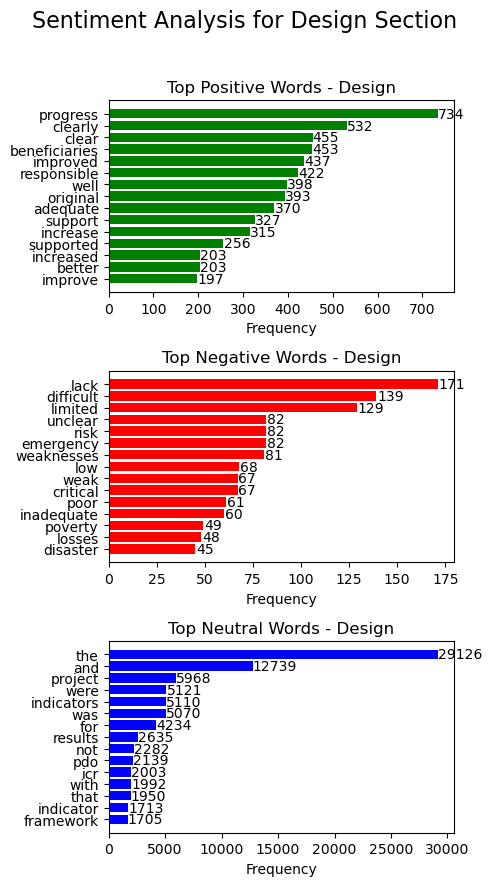

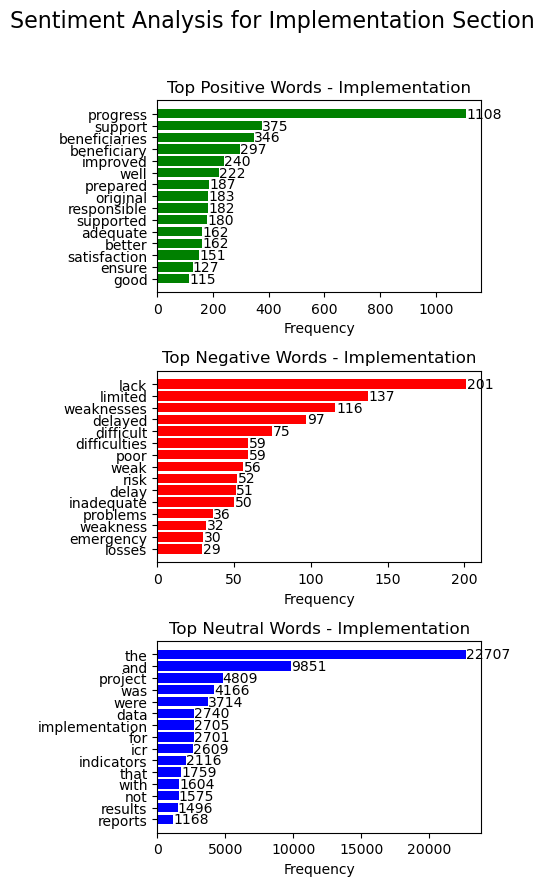

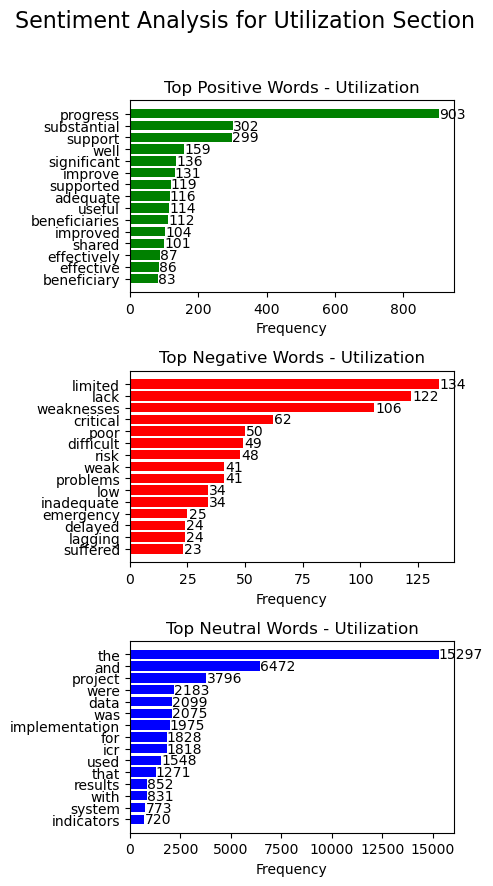

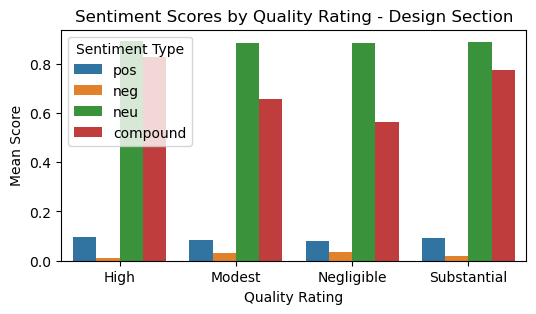

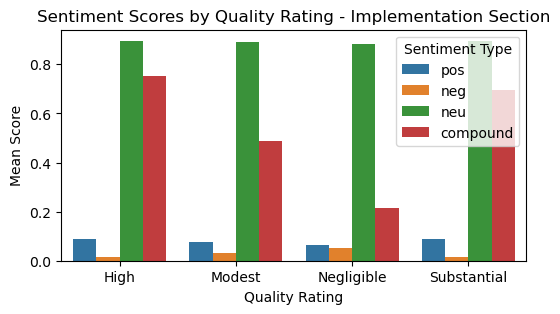

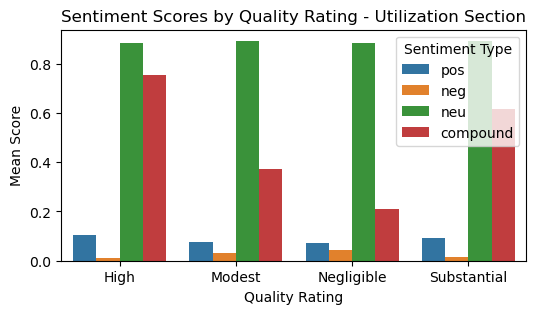

In [ ]:
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np
import seaborn as sns


def extract_sentiment_words(texts):
    analyzer = SentimentIntensityAnalyzer()

    positive_words = Counter()
    negative_words = Counter()
    neutral_words = Counter()

    for text in texts:
        if pd.isna(text):
            continue

        words = word_tokenize(text.lower())

        for word in words:
            if len(word) <= 2 or not word.isalpha():
                continue

            score = analyzer.polarity_scores(word)

            if score["compound"] > 0.2:
                positive_words[word] += 1
            elif score["compound"] < -0.2:
                negative_words[word] += 1
            else:
                neutral_words[word] += 1

    return positive_words, negative_words, neutral_words


def plot_top_words(word_counter, title, ax, n=15, color="steelblue"):
    top_words = dict(word_counter.most_common(n))

    sorted_items = sorted(top_words.items(), key=lambda x: x[1])
    words = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    ax.barh(words, counts, color=color)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Frequency")

    for i, count in enumerate(counts):
        ax.text(count + 0.5, i, str(count), va="center")


def visualize_sentiment(df, section):
    texts = df[f"{section}_text"].tolist()

    pos_words, neg_words, neu_words = extract_sentiment_words(texts)

    fig, axes = plt.subplots(3, 1, figsize=(5, 9))
    fig.suptitle(f"Sentiment Analysis for {section.capitalize()} Section", fontsize=16)

    plot_top_words(
        pos_words,
        f"Top Positive Words - {section.capitalize()}",
        axes[0],
        color="green",
    )
    plot_top_words(
        neg_words, f"Top Negative Words - {section.capitalize()}", axes[1], color="red"
    )
    plot_top_words(
        neu_words, f"Top Neutral Words - {section.capitalize()}", axes[2], color="blue"
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return pos_words, neg_words, neu_words


def plot_sentiment_by_quality(df, section):
    grouped = (
        df.groupby("quality_rating")[
            [
                f"{section}_pos",
                f"{section}_neg",
                f"{section}_neu",
                f"{section}_compound",
            ]
        ]
        .mean()
        .reset_index()
    )

    melted = pd.melt(
        grouped,
        id_vars=["quality_rating"],
        value_vars=[
            f"{section}_pos",
            f"{section}_neg",
            f"{section}_neu",
            f"{section}_compound",
        ],
        var_name="Sentiment Component",
        value_name="Score",
    )

    melted["Sentiment Component"] = melted["Sentiment Component"].apply(
        lambda x: x.replace(f"{section}_", "")
    )

    plt.figure(figsize=(6, 3))
    sns.barplot(x="quality_rating", y="Score", hue="Sentiment Component", data=melted)
    plt.title(f"Sentiment Scores by Quality Rating - {section.capitalize()} Section")
    plt.xlabel("Quality Rating")
    plt.ylabel("Mean Score")
    plt.legend(title="Sentiment Type")
    plt.show()


def compare_words_by_quality(df, section, sentiment_type="positive", top_n=10):
    """
    Compare top words for each quality rating
    sentiment_type can be 'positive', 'negative', or 'neutral'
    """
    quality_ratings = df["quality_rating"].unique()

    fig, axes = plt.subplots(
        len(quality_ratings), 1, figsize=(10, 4 * len(quality_ratings))
    )
    fig.suptitle(
        f"Top {sentiment_type.capitalize()} Words by Quality Rating - {section.capitalize()} Section",
        fontsize=16,
    )

    color_map = {"positive": "green", "negative": "red", "neutral": "blue"}
    color = color_map.get(sentiment_type, "steelblue")

    for i, rating in enumerate(sorted(quality_ratings)):
        filtered_df = df[df["quality_rating"] == rating]
        texts = filtered_df[f"{section}_text"].tolist()

        pos, neg, neu = extract_sentiment_words(texts)

        if sentiment_type == "positive":
            word_counter = pos
        elif sentiment_type == "negative":
            word_counter = neg
        else:  # neutral
            word_counter = neu

        # Plot
        plot_top_words(
            word_counter, f"Quality: {rating}", axes[i], n=top_n, color=color
        )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


visualize_sentiment(df, "design")
visualize_sentiment(df, "implementation")
visualize_sentiment(df, "utilization")
plot_sentiment_by_quality(df, "design")
plot_sentiment_by_quality(df, "implementation")
plot_sentiment_by_quality(df, "utilization")

## Model sentiment analysis and M&E rating

In [5]:
# Prepare features and target
def prepare_features(df, section):
    """ """
    if section == "combined":
        features = df[
            [
                "design_pos",
                "design_neg",
                "design_neu",
                "design_compound",
                "implementation_pos",
                "implementation_neg",
                "implementation_neu",
                "implementation_compound",
                "utilization_pos",
                "utilization_neg",
                "utilization_neu",
                "utilization_compound",
            ]
        ]
    else:
        features = df[
            [
                f"{section}_pos",
                f"{section}_neg",
                f"{section}_neu",
                f"{section}_compound",
            ]
        ]

    return features


def train_and_evaluate_models(df):
    """ """
    le = LabelEncoder()
    y = le.fit_transform(df["quality_rating"])

    # Define sections to analyze
    sections = ["design", "implementation", "utilization", "combined"]

    results = {}

    for section in sections:
        print(f"\nTraining model for {section} section...")

        X = prepare_features(df, section)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        metrics = evaluate_model(clf, X_test, y_test, le, section)
        results[section] = metrics

        print(f"Section: {section}")

        plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section)

    return clf, results


def compare_results(results):
    """
    Compare model performance across sections
    """
    comparison = pd.DataFrame(
        {
            "Section": [section for section in results.keys()],
            "F1 Score": [results[section]["f1_score"] for section in results.keys()],
            "Accuracy": [results[section]["accuracy"] for section in results.keys()],
        }
    )

    plt.figure(figsize=(10, 6))
    comparison.set_index("Section").plot(kind="bar")
    plt.title("Model Performance by Section")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def evaluate_model(clf, X_test, y_test, le, section_name):
    """
    fn to evaluate model
    """

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average="weighted")

    # Add n_classes definition
    n_classes = len(le.classes_)

    evaluation_metrics = {
        "section": section_name,
        "f1_score": f1,
        "accuracy": (y_pred == y_test).mean(),
        "class_f1_scores": f1_score(
            y_test, y_pred, average=None, labels=range(n_classes)
        ),
        "class_names": le.classes_,
        "confusion_matrix": pd.crosstab(
            pd.Series(y_test, name="Actual"),
            pd.Series(y_pred, name="Predicted"),
            rownames=["Actual"],
            colnames=["Predicted"],
        ),
    }

    return evaluation_metrics


def plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section_name):
    y_pred_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors = ["blue", "red", "green", "purple"]
    for i, color, class_name in zip(range(n_classes), colors, le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        axes[0].plot(
            fpr, tpr, color=color, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})"
        )

    axes[0].plot([0, 1], [0, 1], "k--", lw=2)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"ROC Curve for {section_name}")
    axes[0].legend(loc="lower right")

    cm = confusion_matrix(y_test, y_pred)

    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
        ax=axes[1],
    )
    axes[1].set_ylabel("Actual")
    axes[1].set_xlabel("Predicted")
    axes[1].set_title(f"Normalized Confusion Matrix for {section_name}")

    plt.tight_layout()
    plt.show()


Training model for design section...
Section: design


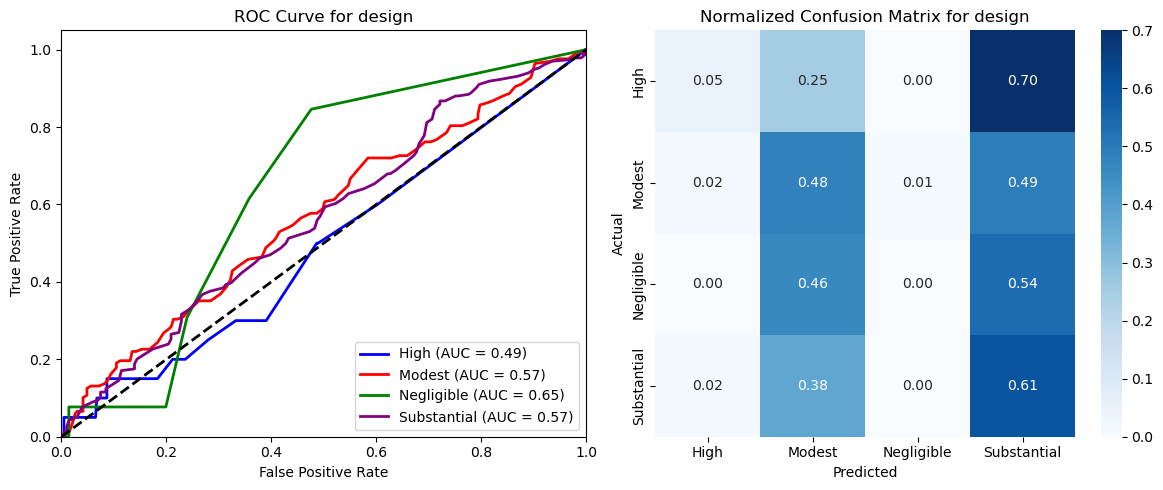


Training model for implementation section...
Section: implementation


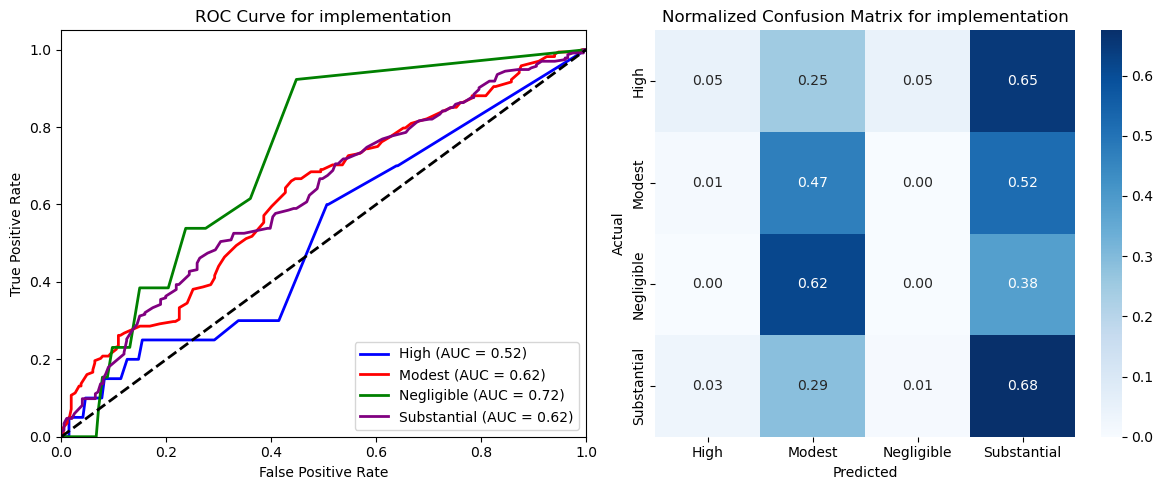


Training model for utilization section...
Section: utilization


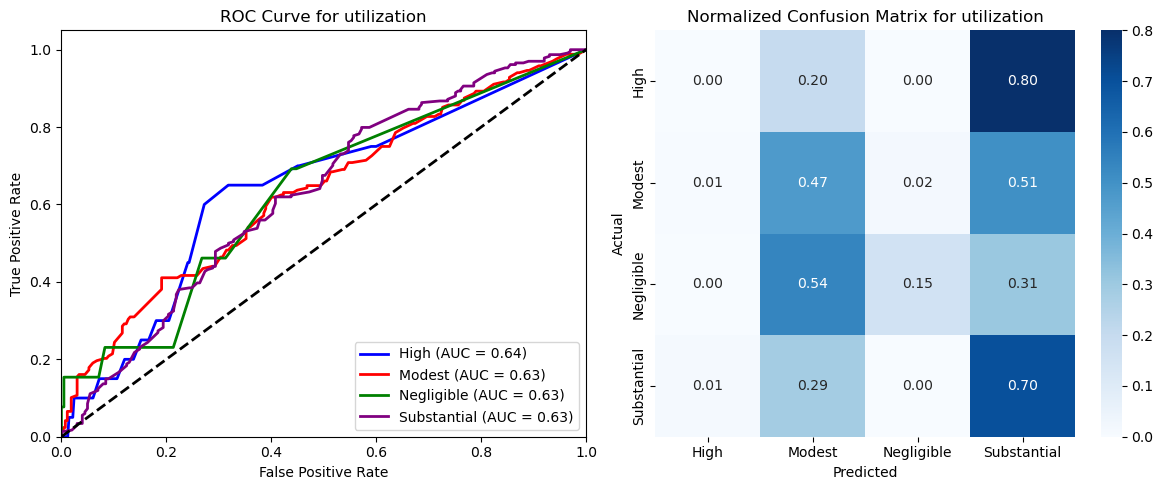


Training model for combined section...
Section: combined


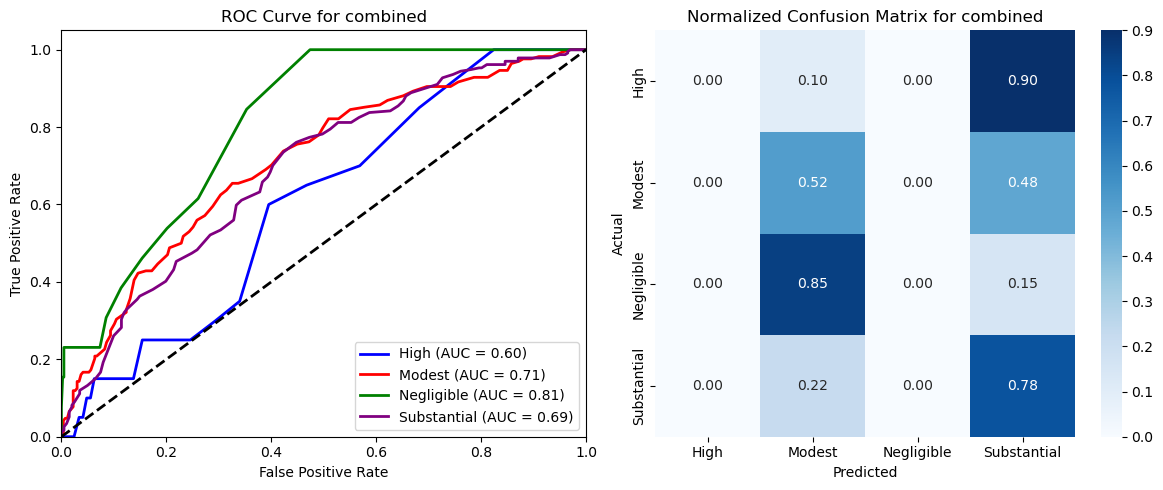

<Figure size 1000x600 with 0 Axes>

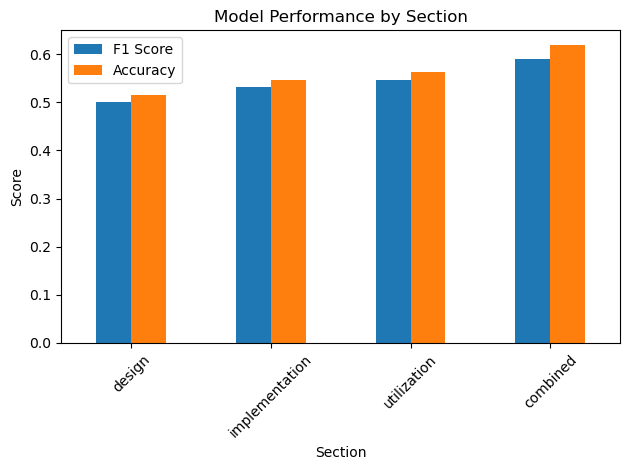

In [ ]:
model, results = train_and_evaluate_models(df)

compare_results(results)

### Feature importance for combined model

In [9]:
def analyze_combined_feature_importance(model, feature_names):
    """ """
    importances = model.feature_importances_

    feature_importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": importances}
    ).sort_values("Importance", ascending=False)

    print("\nFeature Importances for Combined Model:")
    for i, row in feature_importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    plt.figure(figsize=(6, 4))
    plt.title("Feature Importances for Combined Model")
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
    plt.tight_layout()
    plt.show()

    sections = ["design", "implementation", "utilization"]
    section_importance = {}

    for section in sections:
        section_features = [feat for feat in feature_names if feat.startswith(section)]
        section_importance[section] = feature_importance_df[
            feature_importance_df["Feature"].isin(section_features)
        ]["Importance"].sum()

    plt.figure(figsize=(6, 4))
    plt.title("Overall Section Importance")
    section_df = pd.DataFrame(
        {
            "Section": list(section_importance.keys()),
            "Importance": list(section_importance.values()),
        }
    ).sort_values("Importance", ascending=False)

    sns.barplot(x="Section", y="Importance", data=section_df)
    plt.tight_layout()
    plt.show()

    sentiment_components = ["pos", "neg", "neu", "compound"]
    component_importance = {}

    for component in sentiment_components:
        component_features = [
            feat for feat in feature_names if feat.endswith(component)
        ]
        component_importance[component] = feature_importance_df[
            feature_importance_df["Feature"].isin(component_features)
        ]["Importance"].sum()

    # Plot component importance
    plt.figure(figsize=(6, 4))
    plt.title("Sentiment Component Importance")
    component_df = pd.DataFrame(
        {
            "Component": list(component_importance.keys()),
            "Importance": list(component_importance.values()),
        }
    ).sort_values("Importance", ascending=False)

    sns.barplot(x="Component", y="Importance", data=component_df)
    plt.tight_layout()
    plt.show()

    return feature_importance_df


Feature Importances for Combined Model:
design_neg: 0.1032
utilization_compound: 0.0941
implementation_compound: 0.0864
utilization_pos: 0.0856
design_compound: 0.0841
implementation_neg: 0.0836
design_pos: 0.0812
design_neu: 0.0808
implementation_neu: 0.0795
utilization_neu: 0.0739
implementation_pos: 0.0739
utilization_neg: 0.0738


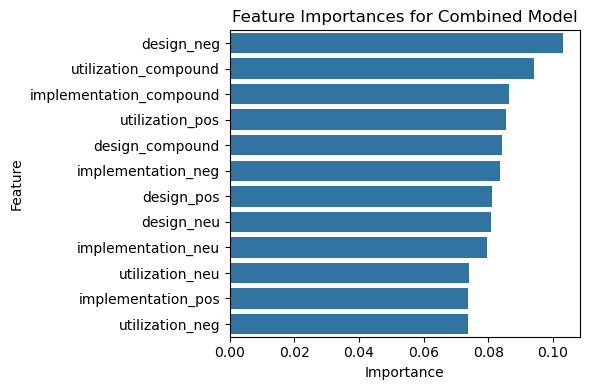

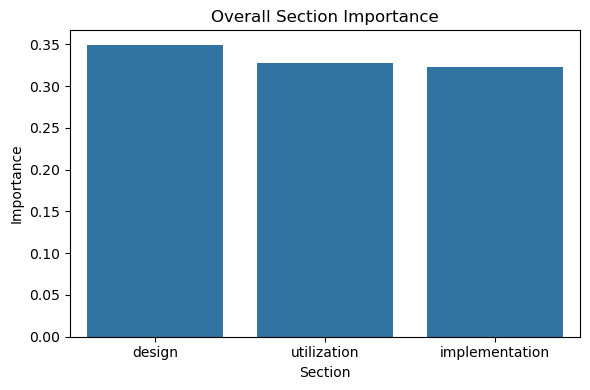

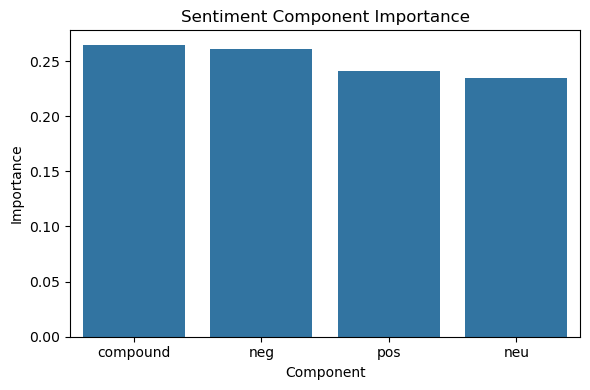

,Feature,Importance
1,design_neg,0.103238
11,utilization_compound,0.094070
7,implementation_compound,0.086401
8,utilization_pos,0.085583
3,design_compound,0.084107
5,implementation_neg,0.083611
0,design_pos,0.081159
2,design_neu,0.080799
6,implementation_neu,0.079529
10,utilization_neu,0.073891


In [11]:
fs = [
    "design_pos",
    "design_neg",
    "design_neu",
    "design_compound",
    "implementation_pos",
    "implementation_neg",
    "implementation_neu",
    "implementation_compound",
    "utilization_pos",
    "utilization_neg",
    "utilization_neu",
    "utilization_compound",
]


analyze_combined_feature_importance(model, fs)


### Results, limitations and biases
The combined model outperforms individual section models, suggesting that sentiment across all three sections provides complementary information for quality prediction. However, the confusion matrices in combiantion to the evaulation of the ROC curve, demonstrate an overfit of the model where Negligile and High Classes are not large enough to overcome the bias towards the other two classes. Due to the misclassification rates, sentiment alone is nto enough determines quality ratings.

For future work, dropping the High and Neligible class and producing a binary classifation model could overcome these issues. 